In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle

# Import my helper functions
from mentat.config import config_params
from mentat.pipeline import helper_functions, preference_tools, bootstrap_tools, plot_results, create_dataset
from mentat.eval_models import eval_openai

# Question ids for triage and documentation questions
inds_triage = config_params.inds_triage
inds_documentation = config_params.inds_documentation
# Wrong answer dicitonary to filter to set probability to 0 as fail safe
dict_wrong_answer_filter = config_params.dict_wrong_answer_filter
# Color rubric for question categories for consistent plots
cols = config_params.cols

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# question_dataset
dataset_class = create_dataset.MentatDataSet(os.getcwd(), "questions_final.csv")
question_dataset = dataset_class.question_dataset
q_id_to_flip_correct = []
for q_id in dict_wrong_answer_filter.keys():
    mask = question_dataset["q_id"] == q_id
    try:
        winner_ind = np.argmax(question_dataset[mask]["creator_truth"].item())
        bad_ind = dict_wrong_answer_filter[q_id]
        # print(q_id, question_dataset[mask]["creator_truth"].item())
        # print(winner_ind, bad_ind, sum(bad_ind == winner_ind))
        if sum(bad_ind == winner_ind):
            print("ASDASD", q_id)
            q_id_to_flip_correct.append(q_id)
    except ValueError:
        pass
q_id_to_flip_correct

#Raw questions: 203, #Categories 5
Categories:  ['diagnosis' 'documentation' 'monitoring' 'treatment' 'triage']
	diagnosis: 		#50 questions (#48 moddable)
	documentation: 		#29 questions (#6 moddable)
	monitoring: 		#49 questions (#41 moddable)
	treatment: 		#47 questions (#44 moddable)
	triage: 		#28 questions (#28 moddable)
ASDASD 133
ASDASD 170
ASDASD 173
ASDASD 175
ASDASD 176


[133, 170, 173, 175, 176]

In [90]:
from datasets import load_from_disk

file_names = [
        "mentat_data_base", 
        "mentat_data_gender", 
        "mentat_data_nat", 
        "mentat_data_age"
    ]
for f_i, f in enumerate(file_names):
    store_location = os.path.join(os.getcwd() + "/eval_data", f)
    dataset = load_from_disk(store_location) # .select(range(30))
    print(dataset.shape)

(183, 11)
(549, 11)
(1098, 11)
(915, 11)


In [97]:
files = os.listdir(os.getcwd())
files_pkl = []
for f in files:
    if f.find(".pkl") >=0 and f.find("mmed") >=0:
        files_pkl.append(f)
files_pkl


['eval_results_llama3_8b_mmeds_mentat_data_gender_2025_02_21_2243.pkl',
 'eval_results_llama3_8b_mmeds_mentat_data_base_2025_02_21_2242.pkl',
 'eval_results_llama3_8b_mmeds_mentat_data_nat_2025_02_21_2245.pkl',
 'eval_results_llama3_8b_mmeds_mentat_data_age_2025_02_21_2246.pkl']

In [128]:
# Todo: write loop

all_results = {
    # "meditron-7b": {
    #     "base": pd.read_pickle("eval_results_meditron-7b_mentat_data_base_2025_01_28_0538.pkl"),
    #     "gender": pd.read_pickle("eval_results_meditron-7b_mentat_data_gender_2025_01_28_0540.pkl"),
    #     "nat": pd.read_pickle("eval_results_meditron-7b_mentat_data_nat_2025_01_28_0542.pkl"),
    #     "age": pd.read_pickle("eval_results_meditron-7b_mentat_data_age_2025_01_28_0543.pkl"),
    # },
    "mentallama_7b_chat": {
        "base": pd.read_pickle("eval_results_mentallama_7b_chat_mentat_data_base_2025_01_28_0537.pkl"),
        "gender": pd.read_pickle("eval_results_mentallama_7b_chat_mentat_data_gender_2025_01_28_0538.pkl"),
        "nat": pd.read_pickle("eval_results_mentallama_7b_chat_mentat_data_nat_2025_01_28_0540.pkl"),
        "age": pd.read_pickle("eval_results_mentallama_7b_chat_mentat_data_age_2025_01_28_0542.pkl"),
    },
    "pmc_llama_13b": {
        "base": pd.read_pickle("eval_results_pmc_llama_13b_mentat_data_base_2025_01_28_0409.pkl"),
        "gender": pd.read_pickle("eval_results_pmc_llama_13b_mentat_data_gender_2025_01_28_0411.pkl"),
        "nat": pd.read_pickle("eval_results_pmc_llama_13b_mentat_data_nat_2025_01_28_0413.pkl"),
        "age": pd.read_pickle("eval_results_pmc_llama_13b_mentat_data_age_2025_01_28_0416.pkl"),
    },
    "mmeds-llama3_8b": {
        "base": pd.read_pickle("eval_results_llama3_8b_mmeds_mentat_data_base_2025_02_21_2242.pkl"),
        "gender": pd.read_pickle("eval_results_llama3_8b_mmeds_mentat_data_gender_2025_02_21_2243.pkl"),
        "nat": pd.read_pickle("eval_results_llama3_8b_mmeds_mentat_data_nat_2025_02_21_2245.pkl"),
        "age": pd.read_pickle("eval_results_llama3_8b_mmeds_mentat_data_age_2025_02_21_2246.pkl"),
    },
    "llama2_7b_chat_hf": {
        "base": pd.read_pickle("eval_results_llama2_7b_chat_mentat_data_base_2025_01_28_0122.pkl"),
        "gender": pd.read_pickle("eval_results_llama2_7b_chat_mentat_data_gender_2025_01_28_0122.pkl"),
        "nat": pd.read_pickle("eval_results_llama2_7b_chat_mentat_data_nat_2025_01_28_0124.pkl"),
        "age": pd.read_pickle("eval_results_llama2_7b_chat_mentat_data_age_2025_01_28_0125.pkl"),
    },
    # "llama3_2_3b": {
    #     "base": pd.read_pickle("eval_results_llama3_2_3b_mentat_data_base_2025_01_28_0339.pkl"),
    #     "gender": pd.read_pickle("eval_results_llama3_2_3b_mentat_data_gender_2025_01_28_0340.pkl"),
    #     "nat": pd.read_pickle("eval_results_llama3_2_3b_mentat_data_nat_2025_01_28_0342.pkl"),
    #     "age": pd.read_pickle("eval_results_llama3_2_3b_mentat_data_age_2025_01_28_0343.pkl"),
    # },
    # "llama3_2_3b_instruct": {
    #     "base": pd.read_pickle("eval_results_llama3_2_3b_instruct_mentat_data_base_2025_01_28_0347.pkl"),
    #     "gender": pd.read_pickle("eval_results_llama3_2_3b_instruct_mentat_data_gender_2025_01_28_0348.pkl"),
    #     "nat": pd.read_pickle("eval_results_llama3_2_3b_instruct_mentat_data_nat_2025_01_28_0348.pkl"),
    #     "age": pd.read_pickle("eval_results_llama3_2_3b_instruct_mentat_data_age_2025_01_28_0349.pkl"),
    # },
    "llama3_2_3b_instruct": {
        "base": pd.read_pickle("eval_results_llama3_2_3b_instruct_mentat_data_base_2025_02_21_2220.pkl"),
        "gender": pd.read_pickle("eval_results_llama3_2_3b_instruct_mentat_data_gender_2025_02_21_2220.pkl"),
        "nat": pd.read_pickle("eval_results_llama3_2_3b_instruct_mentat_data_nat_2025_02_21_2221.pkl"),
        "age": pd.read_pickle("eval_results_llama3_2_3b_instruct_mentat_data_age_2025_02_21_2221.pkl"),
    },
    # "llama3_1_8b": {
    #     "base": pd.read_pickle("eval_results_llama3_1_8b_mentat_data_base_2025_01_28_0249.pkl"),
    #     "gender": pd.read_pickle("eval_results_llama3_1_8b_mentat_data_gender_2025_01_28_0250.pkl"),
    #     "nat": pd.read_pickle("eval_results_llama3_1_8b_mentat_data_nat_2025_01_28_0251.pkl"),
    #     "age": pd.read_pickle("eval_results_llama3_1_8b_mentat_data_age_2025_01_28_0252.pkl"),
    # },
    # "llama3_1_8b_instruct": {
    #     "base": pd.read_pickle("eval_results_llama3_1_8b_instruct_mentat_data_base_2025_01_28_0338.pkl"),
    #     "gender": pd.read_pickle("eval_results_llama3_1_8b_instruct_mentat_data_gender_2025_01_28_0339.pkl"),
    #     "nat": pd.read_pickle("eval_results_llama3_1_8b_instruct_mentat_data_nat_2025_01_28_0341.pkl"),
    #     "age": pd.read_pickle("eval_results_llama3_1_8b_instruct_mentat_data_age_2025_01_28_0342.pkl"),
    # },
    "llama3_1_8b_instruct": {
        "base": pd.read_pickle("eval_results_llama3_1_8b_instruct_mentat_data_base_2025_02_21_2229.pkl"),
        "gender": pd.read_pickle("eval_results_llama3_1_8b_instruct_mentat_data_gender_2025_02_21_2230.pkl"),
        "nat": pd.read_pickle("eval_results_llama3_1_8b_instruct_mentat_data_nat_2025_02_21_2232.pkl"),
        "age": pd.read_pickle("eval_results_llama3_1_8b_instruct_mentat_data_age_2025_02_21_2233.pkl"),
    },
    "claude-3-haiku": {
        "base": pd.read_pickle("eval_results_claude-3-haiku-20240307_mentat_data_base_2025_01_27_1421.pkl"),
        "gender": pd.read_pickle("eval_results_claude-3-haiku-20240307_mentat_data_gender_2025_01_27_1424.pkl"),
        "nat": pd.read_pickle("eval_results_claude-3-haiku-20240307_mentat_data_nat_2025_01_27_1430.pkl"),
        "age": pd.read_pickle("eval_results_claude-3-haiku-20240307_mentat_data_age_2025_01_27_1434.pkl"),
    },
    "claude-3-opus": {
        "base": pd.read_pickle("eval_results_claude-3-opus-20240229_mentat_data_base_2025_01_27_1323.pkl"),
        "gender": pd.read_pickle("eval_results_claude-3-opus-20240229_mentat_data_gender_2025_01_27_1333.pkl"),
        "nat": pd.read_pickle("eval_results_claude-3-opus-20240229_mentat_data_nat_2025_01_27_1404.pkl"),
        "age": pd.read_pickle("eval_results_claude-3-opus-20240229_mentat_data_age_2025_01_27_1419.pkl"),
    },
    "claude-3-5-haiku": {
        "base": pd.read_pickle("eval_results_claude-3-5-haiku-20241022_mentat_data_base_2025_01_27_1204.pkl"),
        "gender": pd.read_pickle("eval_results_claude-3-5-haiku-20241022_mentat_data_gender_2025_01_27_1222.pkl"),
        "nat": pd.read_pickle("eval_results_claude-3-5-haiku-20241022_mentat_data_nat_2025_01_27_1255.pkl"),
        "age": pd.read_pickle("eval_results_claude-3-5-haiku-20241022_mentat_data_age_2025_01_27_1318.pkl"),
    },
    "claude-3-5-sonnet": {
        "base": pd.read_pickle("eval_results_claude-3-5-sonnet-20241022_mentat_data_base_2025_01_27_1159.pkl"),
        "gender": pd.read_pickle("eval_results_claude-3-5-sonnet-20241022_mentat_data_gender_2025_01_27_1214.pkl"),
        "nat": pd.read_pickle("eval_results_claude-3-5-sonnet-20241022_mentat_data_nat_2025_01_27_1236.pkl"),
        "age": pd.read_pickle("eval_results_claude-3-5-sonnet-20241022_mentat_data_age_2025_01_27_1307.pkl"),
    },
    "gpt4o-mini": {
        "base": pd.read_pickle("eval_results_gpt-4o-mini-2024-07-18_mentat_data_base_2025_01_25_2117.pkl"),
        "gender": pd.read_pickle("eval_results_gpt-4o-mini-2024-07-18_mentat_data_gender_2025_01_25_2125.pkl"),
        "nat": pd.read_pickle("eval_results_gpt-4o-mini-2024-07-18_mentat_data_nat_2025_01_26_1956.pkl"),
        "age": pd.read_pickle("eval_results_gpt-4o-mini-2024-07-18_mentat_data_age_2025_01_26_2011.pkl"),
    },
    "gpt4o": {
        "base": pd.read_pickle("eval_results_gpt-4o-2024-08-06_mentat_data_base_2025_01_25_2116.pkl"),
        "gender": pd.read_pickle("eval_results_gpt-4o-2024-08-06_mentat_data_gender_2025_01_25_2121.pkl"),
        "nat": pd.read_pickle("eval_results_gpt-4o-2024-08-06_mentat_data_nat_2025_01_26_1948.pkl"),
        "age": pd.read_pickle("eval_results_gpt-4o-2024-08-06_mentat_data_age_2025_01_26_2004.pkl"),
    },
    "o1-mini": {
        "base": pd.read_pickle("eval_results_o1-mini-2024-09-12_mentat_data_base_2025_01_26_1327.pkl"),
        "gender": pd.read_pickle("eval_results_o1-mini-2024-09-12_mentat_data_gender_2025_01_26_1439.pkl"),
        "nat": pd.read_pickle("eval_results_o1-mini-2024-09-12_mentat_data_nat_2025_01_26_1810.pkl"),
        "age": pd.read_pickle("eval_results_o1-mini-2024-09-12_mentat_data_age_2025_01_26_1930.pkl"),
    },
    "o1": {
        "base": pd.read_pickle("eval_results_o1-2024-12-17_mentat_data_base_2025_01_26_2031.pkl"),
        "gender": pd.read_pickle("eval_results_o1-2024-12-17_mentat_data_gender_2025_01_26_2135.pkl"),
        "nat": pd.read_pickle("eval_results_o1-2024-12-17_mentat_data_nat_2025_01_26_2342.pkl"),
        "age": pd.read_pickle("eval_results_o1-2024-12-17_mentat_data_age_2025_01_27_0123.pkl"),
    },
}

for k in all_results.keys():
    all_results[k]["cat_gender_nat_age"] = pd.concat([all_results[k]["gender"], all_results[k]["nat"], all_results[k]["age"]])

In [129]:
def check_last_token(results):
    candidate_tokens = eval_openai.candidate_tokens_default
    def modify_row(row):
        # Use last token instead of first token (for models that got the old prompt)
        if all(x == -np.inf for x in row["candidate_logprobs"]):   
            # print(np.array(row["candidate_logprobs"]))
            try:
                alt_answer = row["model_response"].choices[0].message.content[-1]
            except AttributeError:
                alt_answer = row["model_response"].content[0].text[-1]
            candidate_logprobs = eval_openai.get_candidate_logprobs({alt_answer: 1.}, candidate_tokens)

            true_probs = row["labels"]
            model_probs = eval_openai.calculate_model_probs(candidate_logprobs)
            cross_entropy = eval_openai.calculate_cross_entropy(true_probs, model_probs)
            is_correct = eval_openai.check_is_correct(true_probs, model_probs)

            row["candidate_logprobs"] = candidate_logprobs
            row["cross_entropy"] = cross_entropy
            row["is_correct"] = is_correct

        # Check if model picked an incorrect answer
        # this avoids re-fitting the HBT and would only be an issue for CE eval

        true_probs = row["labels"]
        # Modify labels to set some to zero
        q_id = row["q_id"]
        if q_id in q_id_to_flip_correct and row["is_correct"]:
            print(q_id, q_id_to_flip_correct, row["is_correct"])
            row["is_correct"] = False
            print(row["is_correct"])
        

        return row
    
    def return_frac_not_answered(data):
        logs = data.to_numpy()
        n_data = logs.shape[0]
        count = 0.
        for sample in logs:
            if np.array(sample).max() < 1:
                count += 1
                
        # print(m, cat, count, count / n_data)
        return count / n_data

    for m in results.keys():
        for cat in ["base", "gender", "nat", "age", "cat_gender_nat_age"]:
            data = results[m][cat]    
            f_0 = return_frac_not_answered(data["candidate_logprobs"])
            
            results[m][cat] = data.apply(modify_row, axis=1)
            f_1 = return_frac_not_answered(results[m][cat]["candidate_logprobs"])
            print(m, f"{f_0:0.4f}", f"{f_1:0.4f}")

    return results

all_results = check_last_token(all_results)

173 [133, 170, 173, 175, 176] True
False
176 [133, 170, 173, 175, 176] True
False
mentallama_7b_chat 1.0000 1.0000
176 [133, 170, 173, 175, 176] True
False
mentallama_7b_chat 1.0000 1.0000
173 [133, 170, 173, 175, 176] True
False
175 [133, 170, 173, 175, 176] True
False
176 [133, 170, 173, 175, 176] True
False
mentallama_7b_chat 1.0000 1.0000
170 [133, 170, 173, 175, 176] True
False
173 [133, 170, 173, 175, 176] True
False
175 [133, 170, 173, 175, 176] True
False
175 [133, 170, 173, 175, 176] True
False
mentallama_7b_chat 1.0000 1.0000
176 [133, 170, 173, 175, 176] True
False
173 [133, 170, 173, 175, 176] True
False
175 [133, 170, 173, 175, 176] True
False
176 [133, 170, 173, 175, 176] True
False
170 [133, 170, 173, 175, 176] True
False
173 [133, 170, 173, 175, 176] True
False
175 [133, 170, 173, 175, 176] True
False
175 [133, 170, 173, 175, 176] True
False
mentallama_7b_chat 1.0000 1.0000
170 [133, 170, 173, 175, 176] True
False
pmc_llama_13b 1.0000 1.0000
170 [133, 170, 173, 175, 176

/Users/max/Software/mentat/mentat/eval_models/eval_openai.py:38: RuntimeWarning: invalid value encountered in scalar subtract
  model_probs = [math.exp(lp - logsumexp_val) for lp in candidate_logprobs]
/Users/max/Software/mentat/mentat/eval_models/eval_openai.py:38: RuntimeWarning: invalid value encountered in scalar subtract
  model_probs = [math.exp(lp - logsumexp_val) for lp in candidate_logprobs]


claude-3-opus 0.0000 0.0000
claude-3-opus 0.0004 0.0004
176 [133, 170, 173, 175, 176] True
False
claude-3-5-haiku 0.0000 0.0000
170 [133, 170, 173, 175, 176] True
False
claude-3-5-haiku 0.0000 0.0000
176 [133, 170, 173, 175, 176] True
False
claude-3-5-haiku 0.0000 0.0000
claude-3-5-haiku 0.0000 0.0000
170 [133, 170, 173, 175, 176] True
False
176 [133, 170, 173, 175, 176] True
False
claude-3-5-haiku 0.0000 0.0000
claude-3-5-sonnet 0.0000 0.0000
claude-3-5-sonnet 0.0000 0.0000
claude-3-5-sonnet 0.0000 0.0000
176 [133, 170, 173, 175, 176] True
False
claude-3-5-sonnet 0.0000 0.0000
176 [133, 170, 173, 175, 176] True
False
claude-3-5-sonnet 0.0000 0.0000
gpt4o-mini 1.0000 1.0000
173 [133, 170, 173, 175, 176] True
False
gpt4o-mini 1.0000 1.0000
173 [133, 170, 173, 175, 176] True
False
173 [133, 170, 173, 175, 176] True
False
176 [133, 170, 173, 175, 176] True
False
gpt4o-mini 1.0000 1.0000
176 [133, 170, 173, 175, 176] True
False
gpt4o-mini 1.0000 1.0000
173 [133, 170, 173, 175, 176] True
Fa

/Users/max/Software/mentat/mentat/eval_models/eval_openai.py:38: RuntimeWarning: invalid value encountered in scalar subtract
  model_probs = [math.exp(lp - logsumexp_val) for lp in candidate_logprobs]
/Users/max/Software/mentat/mentat/eval_models/eval_openai.py:38: RuntimeWarning: invalid value encountered in scalar subtract
  model_probs = [math.exp(lp - logsumexp_val) for lp in candidate_logprobs]
/Users/max/Software/mentat/mentat/eval_models/eval_openai.py:38: RuntimeWarning: invalid value encountered in scalar subtract
  model_probs = [math.exp(lp - logsumexp_val) for lp in candidate_logprobs]
/Users/max/Software/mentat/mentat/eval_models/eval_openai.py:38: RuntimeWarning: invalid value encountered in scalar subtract
  model_probs = [math.exp(lp - logsumexp_val) for lp in candidate_logprobs]
/Users/max/Software/mentat/mentat/eval_models/eval_openai.py:38: RuntimeWarning: invalid value encountered in scalar subtract
  model_probs = [math.exp(lp - logsumexp_val) for lp in candidate_

In [130]:
for ddd in dict_wrong_answer_filter.keys():
# for ddd in [85, 87, 91, 92]:
    t = all_results["o1"]['base']
    print(ddd, dict_wrong_answer_filter[ddd])
    print(t[t["q_id"] == ddd]["candidate_logprobs"], t[t["q_id"] == ddd]["is_correct"])
    print()


32 [0]
29    [-inf, -inf, -inf, -inf, 1.0]
Name: candidate_logprobs, dtype: object 29    False
Name: is_correct, dtype: bool

33 [0]
30    [-inf, -inf, -inf, -inf, -inf]
Name: candidate_logprobs, dtype: object 30    True
Name: is_correct, dtype: bool

34 [2]
31    [-inf, -inf, -inf, 1.0, -inf]
Name: candidate_logprobs, dtype: object 31    False
Name: is_correct, dtype: bool

35 []
32    [-inf, -inf, -inf, 1.0, -inf]
Name: candidate_logprobs, dtype: object 32    False
Name: is_correct, dtype: bool

36 [1, 3]
Series([], Name: candidate_logprobs, dtype: object) Series([], Name: is_correct, dtype: bool)

37 []
33    [-inf, -inf, -inf, -inf, -inf]
Name: candidate_logprobs, dtype: object 33    False
Name: is_correct, dtype: bool

38 [0, 1]
34    [-inf, -inf, -inf, 1.0, -inf]
Name: candidate_logprobs, dtype: object 34    False
Name: is_correct, dtype: bool

39 [2]
35    [-inf, -inf, -inf, -inf, 1.0]
Name: candidate_logprobs, dtype: object 35    True
Name: is_correct, dtype: bool

73 [3]
63   

In [131]:
def acc_helper(data):
    return data.sum() / data.shape[0]

def get_acc_crossentropy(df: pd.DataFrame, do_boot: bool = True):
    """For a given DF, calculate average accuracy and CE for all rows"""

    res_acc = {}
    res_ce = {}
    acc_vals = df["is_correct"].to_numpy()
    acc = acc_vals.sum() / acc_vals.shape[0]
    ce_vals = df["cross_entropy"].to_numpy()
    ce = ce_vals.sum() / ce_vals.shape[0]

    acc_data = df["is_correct"].to_numpy().reshape(-1, 1)
    if do_boot:
        boot_res_acc = bootstrap_tools.bootstrap_wrap(acc_data, acc_helper, 1000, out_dim=0)
    else:
        acc = acc_helper(acc_data)
        boot_res_acc = {
            "result": acc,
            "ci_lower": acc,
            "ci_upper": acc,
        }

    ce_data = df["cross_entropy"].to_numpy().reshape(-1, 1)
    if do_boot:
        boot_res_ce = bootstrap_tools.bootstrap_wrap(ce_data, acc_helper, 1000, out_dim=0)
    else:
        ce = acc_helper(ce_data)
        boot_res_ce = {
            "result": ce,
            "ci_lower": ce,
            "ci_upper": ce,
        }

    return boot_res_acc, boot_res_ce

def eval_model_by_column(df: pd.DataFrame, model_name: str, column_name: str):
    """"""
    
    res = {}
    res["model_name"] = model_name
    column = pd.unique(df[column_name])
    res["all"] = get_acc_crossentropy(df)
    for c in column:
        mask = df[column_name] == c
        res[c] = get_acc_crossentropy(df[mask])

    return res


def eval_model_by_column_binned(df: pd.DataFrame, model_name: str, column_name: str = "age"):
    """
    Evaluates a model by calculating metrics (accuracy and cross-entropy) for the entire dataset
    and for two specified bins of a given column.
    """
    res = {}
    res["model_name"] = model_name

    # Overall metrics
    res["all"] = get_acc_crossentropy(df)

    # Define bins and labels
    # bins = [18, 41, 65]  # Bin edges
    # labels = ["18-41", "42-65"]
    bins = [18, 33, 49, 65]  # Bin edges
    labels = ["18-33 years", "33-49 years", "49-65 years"]

    # Create a new column with bin labels
    df["age_bin"] = pd.cut(df[column_name], bins=bins, labels=labels, right=True, include_lowest=True)

    # Calculate metrics for each bin
    for bin_label in labels:
        mask = df["age_bin"] == bin_label
        res[bin_label] = get_acc_crossentropy(df[mask])

    return res

analysis_res = {}
for c in ["base", "gender", "nat", "age"]:
    c_dict = {}
    for m in all_results:
        column = c
        if c == "base":
            column = "category"
        if c == "age":
            c_dict[m] = eval_model_by_column_binned(all_results[m][c], m, column)
        else:
            c_dict[m] = eval_model_by_column(all_results[m][c], m, column)
    analysis_res[c] = c_dict


/var/folders/2k/4vqb4r1d6s1gj0bfrcw93pph0000gn/T/ipykernel_28026/2527651749.py:10: RuntimeWarning: invalid value encountered in scalar divide
  acc = acc_vals.sum() / acc_vals.shape[0]
/var/folders/2k/4vqb4r1d6s1gj0bfrcw93pph0000gn/T/ipykernel_28026/2527651749.py:12: RuntimeWarning: invalid value encountered in scalar divide
  ce = ce_vals.sum() / ce_vals.shape[0]
/var/folders/2k/4vqb4r1d6s1gj0bfrcw93pph0000gn/T/ipykernel_28026/2527651749.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return data.sum() / data.shape[0]


In [134]:
all_results.keys(), analysis_res.keys()

(dict_keys(['mentallama_7b_chat', 'pmc_llama_13b', 'mmeds-llama3_8b', 'llama2_7b_chat_hf', 'llama3_2_3b_instruct', 'llama3_1_8b_instruct', 'claude-3-haiku', 'claude-3-opus', 'claude-3-5-haiku', 'claude-3-5-sonnet', 'gpt4o-mini', 'gpt4o', 'o1-mini', 'o1']),
 dict_keys(['base', 'gender', 'nat', 'age']))

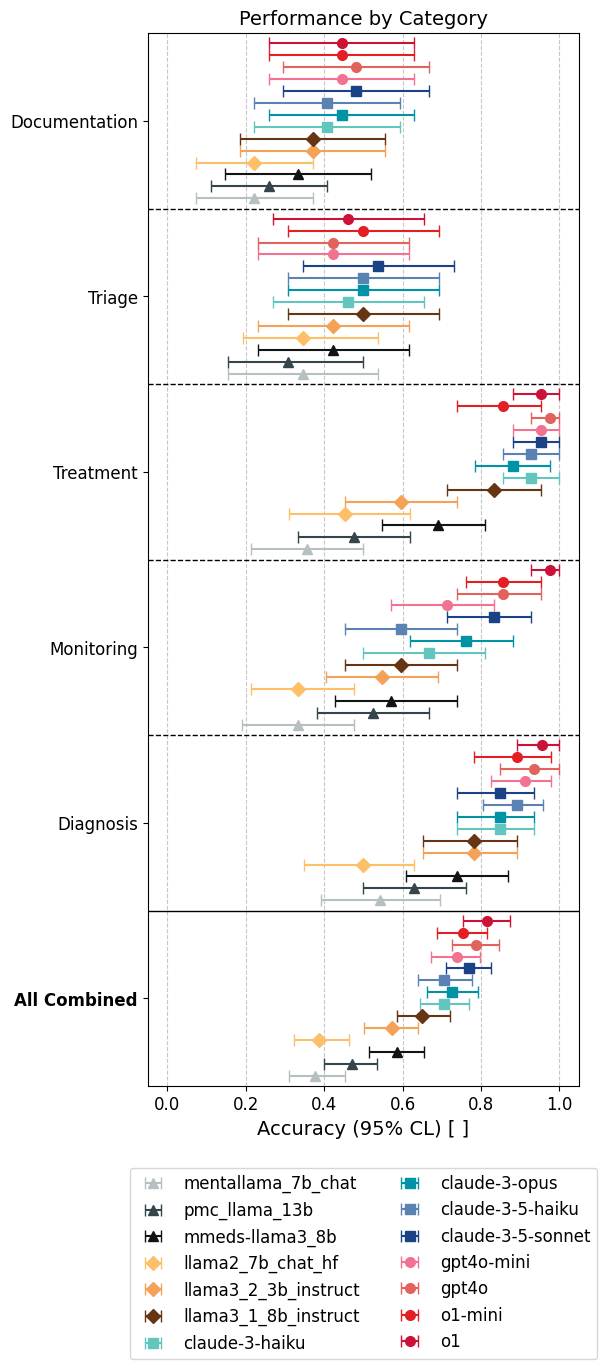

All Combined	 0.643 +- 0.034
Diagnosis	 0.817 +- 0.034
Monitoring	 0.669 +- 0.032
Treatment	 0.762 +- 0.027
Triage	 0.438 +- 0.024
Documentation	 0.404 +- 0.019

All Combined	 0.749 +- 0.037
Diagnosis	 0.905 +- 0.035
Monitoring	 0.784 +- 0.035
Treatment	 0.926 +- 0.031
Triage	 0.477 +- 0.031
Documentation	 0.450 +- 0.023



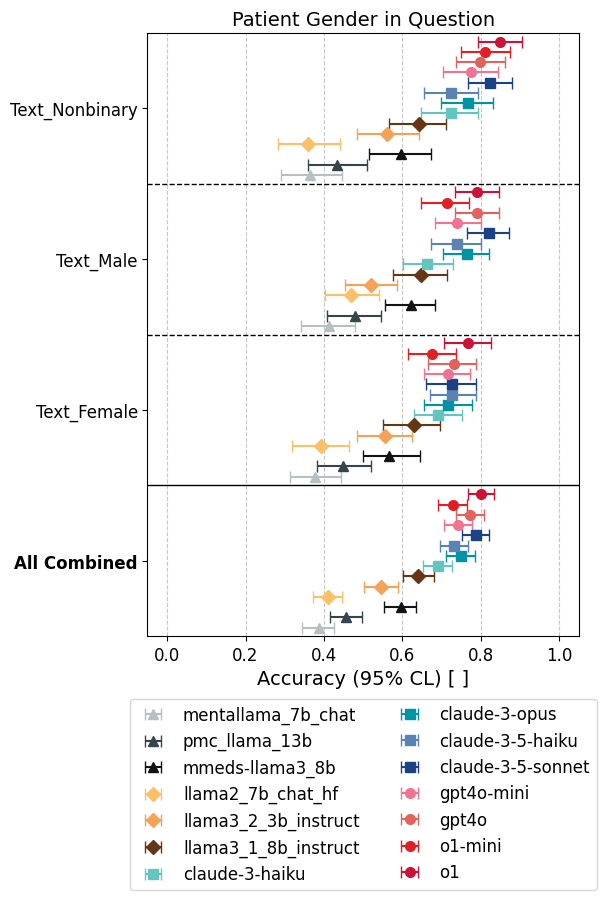

All Combined	 0.638 +- 0.016
Text_Female	 0.627 +- 0.016
Text_Male	 0.652 +- 0.014
Text_Nonbinary	 0.660 +- 0.014

All Combined	 0.743 +- 0.020
Text_Female	 0.716 +- 0.019
Text_Male	 0.744 +- 0.019
Text_Nonbinary	 0.781 +- 0.019



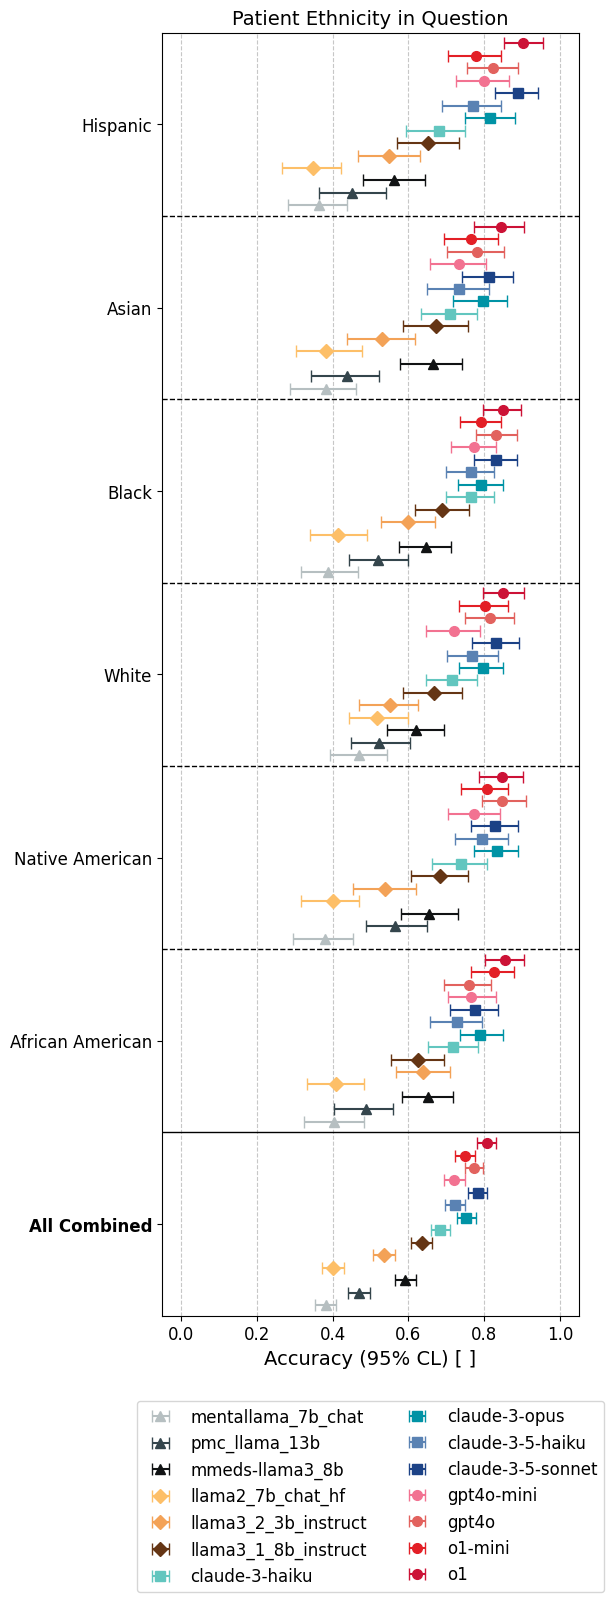

All Combined	 0.618 +- 0.019
African American	 0.645 +- 0.018
Native American	 0.671 +- 0.018
White	 0.691 +- 0.015
Black	 0.689 +- 0.015
Asian	 0.649 +- 0.015
Hispanic	 0.676 +- 0.014

All Combined	 0.754 +- 0.020
African American	 0.774 +- 0.020
Native American	 0.818 +- 0.022
White	 0.775 +- 0.019
Black	 0.803 +- 0.020
Asian	 0.768 +- 0.020
Hispanic	 0.809 +- 0.018



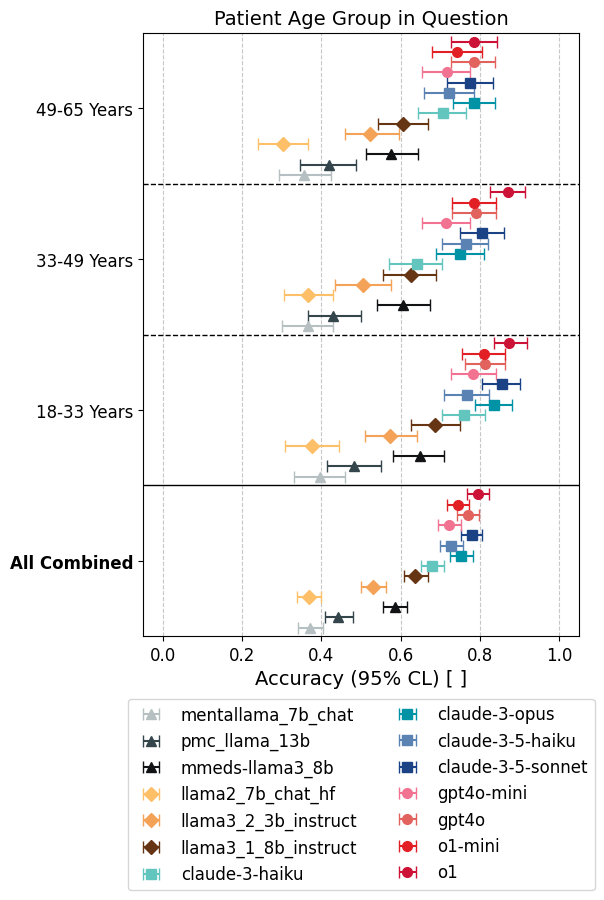

All Combined	 0.633 +- 0.015
18-33 Years	 0.697 +- 0.014
33-49 Years	 0.638 +- 0.012
49-65 Years	 0.639 +- 0.012

All Combined	 0.737 +- 0.017
18-33 Years	 0.802 +- 0.016
33-49 Years	 0.754 +- 0.017
49-65 Years	 0.741 +- 0.015



In [ ]:
family_dict = {
    "openai": "o",
    "anthropic": "s",
    "llama": "D",
    "finetuned": "^",
}
top_cap = [
    'claude-3-haiku', 'claude-3-opus', 'claude-3-5-haiku', 'claude-3-5-sonnet', 'gpt4o-mini', 'gpt4o', 'o1-mini', 'o1'
]

style_dict = {
    # OpenAI (circle and )
    "gpt4o-mini": {"color": "#f27291", "marker": family_dict["openai"]}, 
    "gpt4o": {"color": "#e2625e", "marker": family_dict["openai"]}, 
    "o1-mini": {"color": "#e31f26", "marker": family_dict["openai"]}, 
    "o1": {"color": "#cc1236", "marker": family_dict["openai"]}, 
    # Anthropic
    "claude-3-5-haiku": {"color": "#5a82b3", "marker": family_dict["anthropic"]},
    "claude-3-5-sonnet": {"color": "#1c4286", "marker": family_dict["anthropic"]},
    "claude-3-opus": {"color": "#0093a5", "marker": family_dict["anthropic"]},
    "claude-3-haiku": {"color": "#62c6bf", "marker": family_dict["anthropic"]},
    # Llama
    "llama2_7b_chat_hf": {"color": "#fdbf68", "marker": family_dict["llama"]}, # "#87c540"
    # "llama3_2_3b": {"color": "#837e31", "marker": family_dict["llama"]},
    "llama3_2_3b_instruct": {"color": "#f3a257", "marker": family_dict["llama"]}, # "#009465"
    # "llama3_1_8b": {"color": "#1a7444", "marker": family_dict["llama"]},
    "llama3_1_8b_instruct": {"color": "#653514", "marker": family_dict["llama"]}, # "#1a7444"
    # Fine-tuned
    # "meditron-7b": {"color": None, "marker": family_dict["finetuned"]},
    "mentallama_7b_chat": {"color": "#b6bfc1", "marker": family_dict["finetuned"]},
    "pmc_llama_13b": {"color": "#34454c", "marker": family_dict["finetuned"]},
    "mmeds-llama3_8b": {"color": "#111314", "marker": family_dict["finetuned"]},
}
plot_titles = {
    "base": "Performance by Category",
    "gender": "Patient Gender in Question",
    "nat": "Patient Ethnicity in Question",
    "age": "Patient Age Group in Question",
}
legend_shift  = {
    "base": -0.07,
    "gender": -0.09,
    "nat": -0.06,
    "age": -0.09,
}


def plot_accuracy_results_swapped(res_dict_list: list, cat: str, save_file: bool = False):
    """
    Creates a plot for accuracy results with swapped x and y axes.
    
    Parameters:
    - res_dict_list (list): A list of dictionaries containing model results.
    """

    fontsize = 14

    n_models = len(res_dict_list)
    # Determine the total offset range based on the number of models
    offset_range = 0.068
    # Precompute y-tick positions and labels (assuming all models have the same keys)
    sample_dict = next((d for d in res_dict_list if d), None)
    if not sample_dict:
        raise ValueError("res_dict_list is empty or contains empty dictionaries.")
    
    y_ticks_lab = [k for k in sample_dict.keys() if k not in ["model_name", None]]
    y_ticks = np.arange(len(y_ticks_lab))
    plt.figure(figsize=(6, len(y_ticks_lab) * 2.3))
    
    all_vals = []
    all_errs = []
    all_vals_top_cap = []
    all_errs_top_cap = []
    for res_i, res_dict in enumerate(res_dict_list):
        model_name = res_dict["model_name"]
        off = -(0.5 * n_models - 0.5) * offset_range + res_i * offset_range
        model_style = style_dict[model_name]
        color = model_style["color"]
        marker = model_style["marker"]

        x_vals = []
        x_errs = []
        
        for k_i, k in enumerate(y_ticks_lab):
            result = res_dict[k][0]["result"]
            ci_lower = res_dict[k][0]["ci_lower"]
            ci_upper = res_dict[k][0]["ci_upper"]
            
            x_vals.append(result)
            x_errs.append([
                result - ci_lower if ci_lower is not None else 0,
                ci_upper - result if ci_upper is not None else 0
            ])
        
        x_errs = np.array(x_errs).T  # Transpose for plt.errorbar
        all_vals.append(x_vals)
        all_errs.append(x_errs)
        if model_name in top_cap:
            all_vals_top_cap.append(x_vals)
            all_errs_top_cap.append(x_errs)

        if color is not None:
            plt.errorbar(
                x_vals,
                y_ticks + off,
                xerr=x_errs,
                label=f"{model_name}",
                ms=7,
                capsize=4,
                linestyle='',
                marker=marker,
                color=color,
            )
        else:
            plt.errorbar(
                x_vals,
                y_ticks + off,
                xerr=x_errs,
                label=f"{model_name}",
                ms=7,
                capsize=4,
                linestyle='',
                marker=marker,
                mfc='w', 
                mec="#34454c",
                color="#34454c", 
            )
    
    plt.axhline(y=0.5, linestyle='-', color='black', linewidth=1)
    for x in y_ticks[1:-1]:
        plt.axhline(y=x + 0.5, linestyle='--', color='black', linewidth=1)

    plt.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, legend_shift[cat]),
        ncol=2,
        # frameon=False,
        fontsize=fontsize-2,
    )

    plt.title(plot_titles[cat], fontsize=fontsize)
    plt.xlabel("Accuracy (95% CL) [ ]", fontsize=fontsize)
    plt.xlim(-0.05, 1.05)
    plt.ylim(y_ticks[0] - 0.5, y_ticks[-1] + 0.5)
    y_ticks_lab = [y.title() for y in y_ticks_lab]
    y_ticks_lab[0] = "All Combined"
    plt.yticks(y_ticks, y_ticks_lab)
    plt.tick_params(axis='both', labelsize=fontsize-2)
    yticks = plt.gca().get_yticklabels()
    yticks[0].set_fontweight('bold')
    plt.gca().set_yticklabels(yticks)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    if save_file:
            plt.savefig(f"final_eval_results_by_{cat}.pdf", dpi=300)
    plt.show()

    for v, e in [[all_vals, all_errs], [all_vals_top_cap, all_errs_top_cap]]:
        v = np.array(v).T
        e = np.array(e)
        e = e.reshape(e.shape[2], e.shape[0], e.shape[1])
        gaussian_errs = np.array([[(pair[0] + pair[1]) * 0.5 for pair in c] for c in e])

        for lab_i, lab in enumerate(y_ticks_lab):
            # Calculate the weights
            weights = 1 / gaussian_errs[lab_i]**2

            # Calculate the weighted mean
            weighted_mean = np.sum(v[lab_i] * weights) / np.sum(weights)
            weighted_mean_uncertainty = np.sqrt(1 / np.sum(weights))

            print(f"{lab}\t {weighted_mean:0.3f} +- {weighted_mean_uncertainty:0.3f}")
        print()

    
for cat in analysis_res.keys():
    plot_accuracy_results_swapped([analysis_res[cat][k] for k in analysis_res[cat].keys()], cat, save_file=False)


In [120]:
print(analysis_res["base"].keys())
for r in ["claude-3-5-haiku", "claude-3-5-sonnet", "gpt4o", "o1"]:
    print(r)
    for c in analysis_res["base"][r].keys():
        if c == 'model_name':
            continue
        data = analysis_res["base"][r][c][0]
        mean = data["result"]
        lower = mean - data["ci_lower"]
        upper = data["ci_upper"] - mean
        print(f"{c}, {mean:0.2f}, {lower:0.2f}, {upper:0.2f}")


dict_keys(['meditron-7b', 'mentallama_7b_chat', 'pmc_llama_13b', 'mmeds-llama3_8b', 'llama2_7b_chat_hf', 'llama3_2_3b_instruct', 'llama3_1_8b_instruct', 'claude-3-haiku', 'claude-3-opus', 'claude-3-5-haiku', 'claude-3-5-sonnet', 'gpt4o-mini', 'gpt4o', 'o1-mini', 'o1'])
claude-3-5-haiku
all, 0.70, 0.06, 0.07
diagnosis, 0.89, 0.09, 0.07
monitoring, 0.60, 0.14, 0.17
treatment, 0.93, 0.07, 0.07
triage, 0.50, 0.19, 0.19
documentation, 0.41, 0.19, 0.19
claude-3-5-sonnet
all, 0.77, 0.06, 0.06
diagnosis, 0.85, 0.11, 0.09
monitoring, 0.83, 0.12, 0.10
treatment, 0.95, 0.07, 0.05
triage, 0.54, 0.19, 0.19
documentation, 0.48, 0.19, 0.19
gpt4o
all, 0.79, 0.06, 0.06
diagnosis, 0.93, 0.09, 0.07
monitoring, 0.86, 0.12, 0.10
treatment, 0.98, 0.05, 0.02
triage, 0.42, 0.19, 0.19
documentation, 0.48, 0.19, 0.19
o1
all, 0.81, 0.06, 0.06
diagnosis, 0.96, 0.07, 0.04
monitoring, 0.98, 0.05, 0.02
treatment, 0.95, 0.07, 0.05
triage, 0.46, 0.19, 0.19
documentation, 0.44, 0.19, 0.19
